In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
# load data after processing
df = pd.read_csv('df_processed.csv', index_col=0, parse_dates=True).reset_index(names='Date')
print(df.shape)
df

(743, 857)


,Date,RPI,W875RX1,DSPIC96,PIROA,PSAVERT,DPCERA3M086SBEA,PCE,W055RC1,USASARTMISMEI,...,CCUSSP02CNM650N_3M_lag,CCUSSP02CNM650N_6M_lag,CCUSSP02CNM650N_9M_lag,CCUSSP02CNM650N_12M_lag,CCUSSP02CNM650N_18M_lag,S&P500_3M_lag,S&P500_6M_lag,S&P500_9M_lag,S&P500_12M_lag,S&P500_18M_lag
0,1961-10-01,27.815,28.2,26.7,0.7,0.4,0.103,2.1,0.2,0.617339,...,0.0000,0.0000,0.0000,0.0000,0.0000,2.12,0.25,3.67,-0.13,-0.97
1,1961-11-01,25.495,24.5,23.5,0.4,-0.1,0.161,3.4,0.3,0.246190,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.31,1.25,1.66,2.15,1.46
2,1961-12-01,17.274,14.8,15.7,0.4,0.0,0.116,2.5,0.2,-0.022084,...,0.0000,0.0000,0.0000,0.0000,0.0000,-1.34,-1.92,1.62,2.57,1.09
3,1962-01-01,-2.890,-3.7,-6.4,-0.5,-0.3,0.005,0.8,0.7,0.266469,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.89,2.12,0.25,3.67,-1.41
4,1962-02-01,12.252,13.1,11.5,0.5,0.5,-0.008,0.8,0.2,-0.078543,...,0.0000,0.0000,0.0000,0.0000,0.0000,2.70,1.31,1.25,1.66,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,2023-04-01,-17.485,-4.6,33.7,5.9,0.0,0.162,81.2,-53.0,0.067919,...,-0.2331,0.1971,0.0338,0.2439,-0.0730,237.10,286.36,344.91,-398.48,297.84
739,2023-05-01,38.645,30.2,54.6,3.4,0.1,0.154,44.0,-16.2,0.477194,...,0.1920,-0.1511,0.1648,0.0746,-0.0188,-106.45,208.13,-175.29,0.22,-38.38
740,2023-06-01,5.338,15.6,-9.0,-19.5,-0.5,0.293,77.6,21.7,-0.060139,...,-0.0764,-0.1558,0.2024,0.0336,-0.0012,139.16,-240.61,-369.38,-346.77,199.18
741,2023-07-01,18.291,42.1,-1.1,3.7,-0.4,0.542,110.0,26.8,0.405517,...,0.0547,-0.2331,0.1971,0.0338,-0.0062,60.17,237.10,286.36,344.91,-250.63


# Train Test Split

In [4]:
split_date = '1980-01-01'
df_train, df_test = df[df['Date'] < split_date], df[df['Date'] >= split_date]

print(f'df_train: {np.round((df_train.shape[0]/df.shape[0])*100, 2)} %')
print(f'df_test: {np.round((df_test.shape[0]/df.shape[0])*100, 2)} %')

df_train: 29.48 %
df_test: 70.52 %


In [5]:
# Split df_train and df_test
X_train = df_train.drop(['Date', 'Regime'], axis=1)
y_train = df_train['Regime']

X_test = df_test.drop(['Date', 'Regime'], axis=1)
y_test = df_test['Regime']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((219, 855), (219,), (524, 855), (524,))

In [6]:
# Check recession months
y_train_recession = y_train[y_train == 1].count()
y_test_recession = y_test[y_test == 1].count()
df_recession = df[df['Regime']==1].shape[0]

print(f'df: {df_recession} recession months ({np.round((df_recession/df.shape[0])*100,2)} %)')
print(f'y_train: {y_train_recession} recession months ({np.round((y_train_recession/y_train.shape[0])*100,2)} %)')
print(f'y_test: {y_test_recession} recession months ({np.round((y_test_recession/y_test.shape[0])*100,2)} %)')

df: 85 recession months (11.44 %)
y_train: 27 recession months (12.33 %)
y_test: 58 recession months (11.07 %)


# Scaling

In [7]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((219, 855), (524, 855))

# Feature Selection

## Lasso Regularization

In [8]:
# Create a range of alpha values to search
alphas = np.logspace(-5, 5, 100) # 10**-5 ~ 10**5

# Create LassoCV model with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5)

# Fit the model to the training data
lasso_cv.fit(X_train_scaled, y_train)

# Print the selected alpha
print("Selected Alpha:", lasso_cv.alpha_)

Selected Alpha: 0.05462277217684343


In [9]:
# Create a Lasso model
selected_alpha = lasso_cv.alpha_
lasso_model = Lasso(alpha = selected_alpha)

# Fit the Lasso model on the training data
lasso_model.fit(X_train_scaled, y_train)

# Get the selected features
selected_features_lasso = X_train.columns[lasso_model.coef_ != 0]

# Transform the original dataset to include only the selected features
X_train_selected_lasso = X_train_scaled[:, lasso_model.coef_ != 0]
X_test_selected_lasso = X_test_scaled[:, lasso_model.coef_ != 0]

# Selected feature names
print('Number of Selected Features with Lasso: ', len(selected_features_lasso))
print(selected_features_lasso)

Number of Selected Features with Lasso:  9
Index(['W875RX1', 'USALOCOSPNOSTSAM', 'USGOOD', 'MANEMP', 'TB3SMFFM_3M_lag',
       'TB3SMFFM_6M_lag', 'T1YFFM_3M_lag', 'T1YFFM_6M_lag', 'T1YFFM_9M_lag'],
      dtype='object')


## Ridge Regularization

In [10]:
# Create and fit Ridge model
alpha = 1.0  # We can adjust the alpha (regularization strength)
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_scaled, y_train)

# Get the magnitudes of coefficients
coeff_magnitudes = np.abs(ridge_model.coef_)

# Sort features based on magnitudes
sorted_features = np.argsort(coeff_magnitudes)[::-1]

# Select top k features (adjust k based on our preference)
k = 10
selected_features_ridge = df.columns[sorted_features[:k]]

# Create X_train_selected and X_test_selected
X_train_selected_ridge = X_train_scaled[:, sorted_features[:k]]
X_test_selected_ridge = X_test_scaled[:, sorted_features[:k]]

# Print selected features
print('Selected Features with Rasso: ', k)
print(selected_features_ridge)

Selected Features with Rasso:  10
Index(['WPU083_3M_lag', 'USALOCOSPNOSTSAM_9M_lag', 'USALOCODWORMLSAM',
       'PPICMM_3M_lag', 'WPUSI012011_6M_lag', 'WPUSI012011_3M_lag',
       'GS10_12M_lag', 'CCUSSP01DEM650N_12M_lag', 'GS10_18M_lag', 'S&P500'],
      dtype='object')


## Elastic Net Regularization

In [11]:
# # We can set more granular options (but takes more time)
# alphas = np.logspace(-4, 4, 100)
# l1_ratios = np.linspace(0.1, 0.9, 9)

# Create and fit Elastic Net model with cross-validation
elastic_net = ElasticNetCV(alphas=[0.1, 1, 10], l1_ratio=[0.1, 0.5, 0.9], cv=5)
elastic_net.fit(X_train_scaled, y_train)

# Get selected features
selected_features_en = [feature for feature, coef in zip(df.columns, elastic_net.coef_) if coef != 0]

# Create X_train_selected and X_test_selected
X_train_selected_en = X_train_scaled[:, elastic_net.coef_ != 0]
X_test_selected_en = X_test_scaled[:, elastic_net.coef_ != 0]

# Evaluate model performance
performance = elastic_net.score(X_test_scaled, y_test)

# Print results
print('Number of Selected Features with Elastic Net:', len(selected_features_en))
print('Best Alpha: ', elastic_net.alpha_)
print('Best l1_ratio: ', elastic_net.l1_ratio_)
print('Model Performance: ', np.round(performance, 5))

Number of Selected Features with Elastic Net: 16
Best Alpha:  0.1
Best l1_ratio:  0.5
Model Performance:  0.35919


# Models

In [12]:
# Set feature selection
# We use elastic net for now...
selected_features = selected_features_en
X_train_selected = X_train_selected_en
X_test_selected = X_test_selected_en

# # To use all features without feature selection...
# selected_features = df.columns.drop(['Regime', 'Date'])
# X_train_selected = X_train_scaled
# X_test_selected = X_test_scaled

X_train_selected.shape, y_train.shape, X_test_selected.shape, y_test.shape

((219, 16), (219,), (524, 16), (524,))

In [13]:
def get_recession_periods(df):
  '''
  Returns the first and last months of the recessionary period.
  ----------
  Parameters
  ----------
  df : data frame with stock price and regime indicator (recession: 1, normal: 0)
  '''
  dates = []
  recession = 1
  normal = 0

  regime = normal
  for i, j, k in zip(df.Regime, df.index, range(len(df))):
    if i == recession and regime == normal: # regime changes from normal to recession
      regime_span = []
      regime = recession
      regime_span.append(j)
    if i == normal and regime == recession: # regime changes from recession to normal
      regime = normal
      regime_span.append(df.index[k-1])
      dates.append(regime_span)
    if i == recession and j == df.index[-1]:
      regime_span.append(j)
  return dates

# Create recession spans and sample range for plots
recession_df = df[['Date', 'Regime']]
recession_df.set_index('Date', inplace = True)
rec_spans = get_recession_periods(recession_df)
sample_range = pd.date_range(start = recession_df.index[0], end = recession_df.index[-1], freq = "MS")

In [14]:
def plot_recession_probabilities(model, name):
  '''
  Returns a plot of the estimated probability of recession
  ----------
  Parameters
  ----------
  model: fitted model
  name: model name (string)
  '''
  # Get probability predictions on the selected training and test data
  prob_predictions_train = model.predict_proba(X_train_selected)[:, 1]
  prob_predictions_test = model.predict_proba(X_test_selected)[:, 1]

  # Concatenate probability predictions from training and test data
  prob_predictions = np.concatenate([prob_predictions_train, prob_predictions_test])

  # Plot the recession prediction probabilities over time
  plt.figure(figsize=(20, 5))
  plt.plot(sample_range.to_series().values, prob_predictions)

  # Add shaded regions to indicate recession spans
  for i in range(len(rec_spans)):
      plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')

  # Add a dashed line at y=0.5 for reference
  plt.axhline(y=0.5, color='r', ls='dashed', alpha=0.5)

  # Set plot title, x-axis label, and y-axis label
  plt.title(f'Recession Prediction Probabilities with {name}')
  plt.xlabel('Time')
  plt.ylabel('Recession Probability')
  plt.show()

In [15]:
def evaluate_model(model, name):
  '''
  Returns a confusion matrix and a classification report
  ----------
  Parameters
  ----------
  model: fitted model
  name: model name (string)
  '''
  print(f'----------------- Training set: {name} --------------------')
  print(confusion_matrix(y_train, model.predict(X_train_selected)))
  print(classification_report(y_train, model.predict(X_train_selected)))

  print(f'----------------- Test set: {name} ------------------------')
  print(confusion_matrix(y_test, model.predict(X_test_selected)))
  print(classification_report(y_test, model.predict(X_test_selected)))

In [16]:
def plot_feature_importance(model, name):
  '''
  Returns a plot of the feature importance
  If the feature importance is not available, returns the coefficeint
  ----------
  Parameters
  ----------
  model: fitted model
  name: model name (string)
  '''
  # Check if the model has feature_importances_
  if hasattr(model, 'feature_importances_'):
      feature_importance = model.feature_importances_
      title = 'Feature Importance'
  else:
      feature_importance = model.coef_.ravel()
      title = 'Coefficient'

  # Create a DataFrame
  df = pd.DataFrame(feature_importance, index=selected_features, columns=[title])
  df = df.sort_values(title, ascending=True)

  # Plot the feature importance
  df.plot(kind='barh', figsize=(6, 4))
  plt.title(f'{title}: {name}', fontsize=10)
  plt.xlabel(title, fontsize=10)
  plt.ylabel('Features', fontsize=10)
  plt.tick_params(axis='both', labelsize=8)
  plt.show()

## Logistic Regression

In [17]:
# Logistic Regression

# Create and fit a logistic regression model
LR = LogisticRegression(class_weight='balanced', random_state=42)
LR.fit(X_train_selected, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

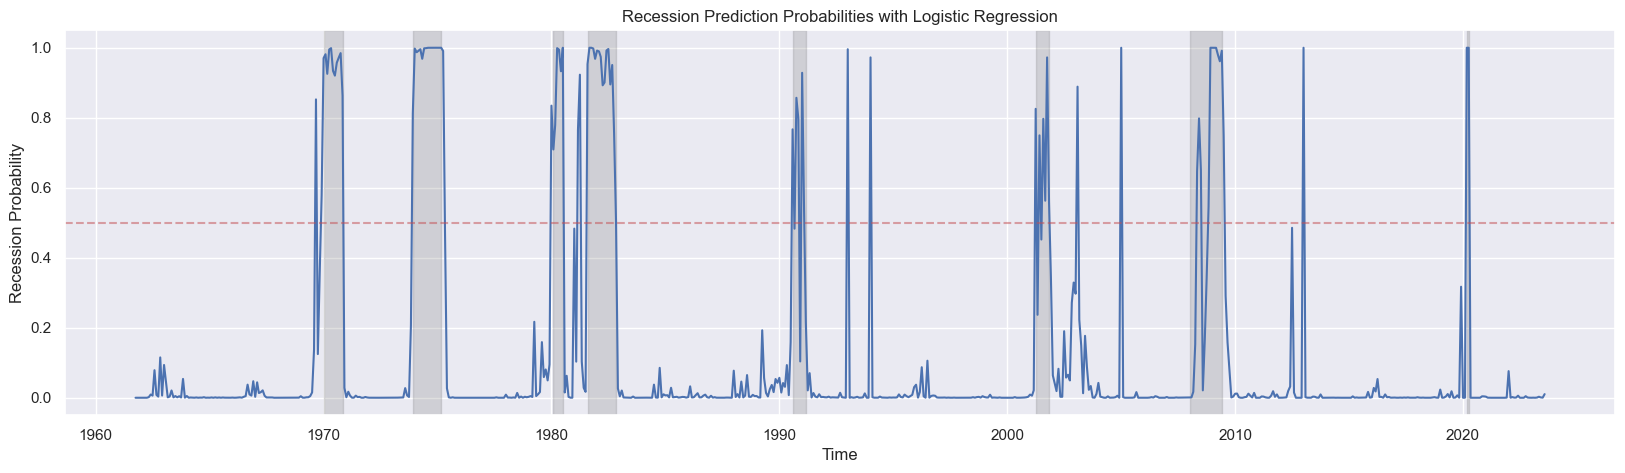

In [18]:
# Plot recession probabilities
plot_recession_probabilities(LR, 'Logistic Regression')

In [19]:
evaluate_model(LR, 'Logistic Regression')

----------------- Training set: Logistic Regression --------------------
[[189   3]
 [  0  27]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       192
         1.0       0.90      1.00      0.95        27

    accuracy                           0.99       219
   macro avg       0.95      0.99      0.97       219
weighted avg       0.99      0.99      0.99       219

----------------- Test set: Logistic Regression ------------------------
[[457   9]
 [ 12  46]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       466
         1.0       0.84      0.79      0.81        58

    accuracy                           0.96       524
   macro avg       0.91      0.89      0.90       524
weighted avg       0.96      0.96      0.96       524



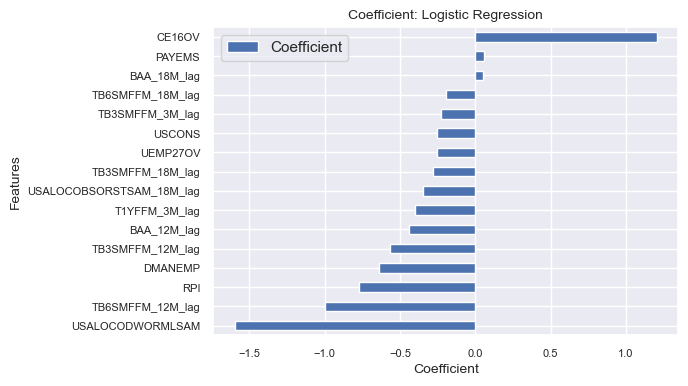

In [20]:
plot_feature_importance(LR, 'Logistic Regression');

## Random Forest

In [21]:
# Random Forest

# Create and fit RandomForestClassifier model
RF = RandomForestClassifier()
RF.fit(X_train_selected, y_train)

RandomForestClassifier()

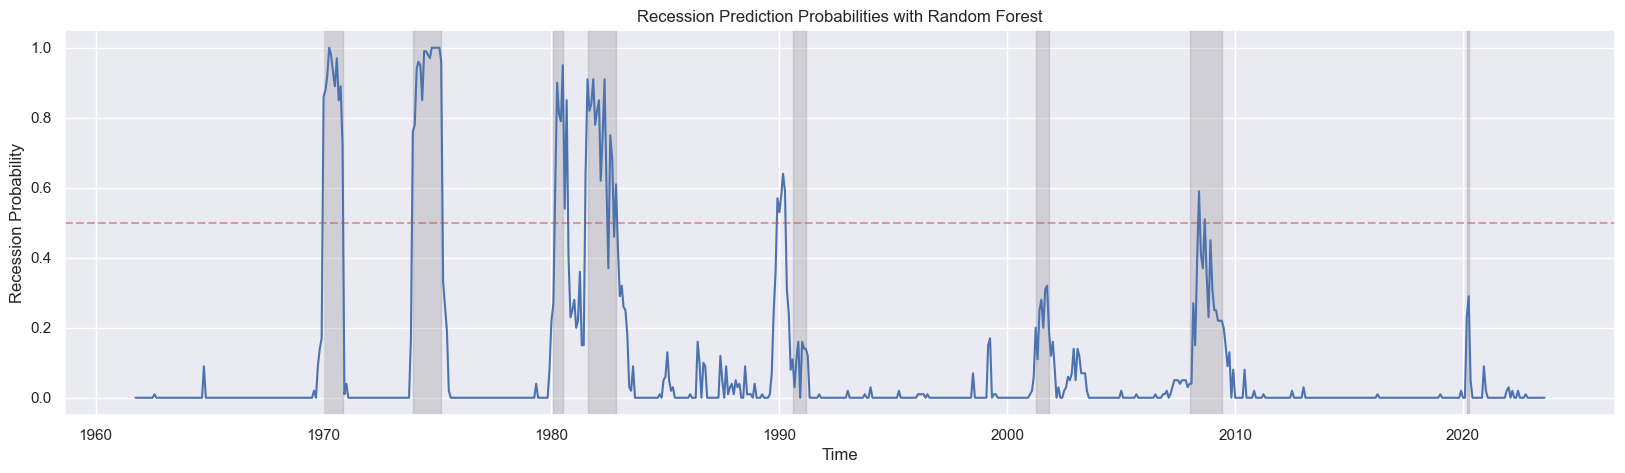

In [22]:
plot_recession_probabilities(RF, 'Random Forest');

In [23]:
evaluate_model(RF, 'Random Forest')

----------------- Training set: Random Forest --------------------
[[192   0]
 [  0  27]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       192
         1.0       1.00      1.00      1.00        27

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219

----------------- Test set: Random Forest ------------------------
[[458   8]
 [ 37  21]]
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       466
         1.0       0.72      0.36      0.48        58

    accuracy                           0.91       524
   macro avg       0.82      0.67      0.72       524
weighted avg       0.90      0.91      0.90       524



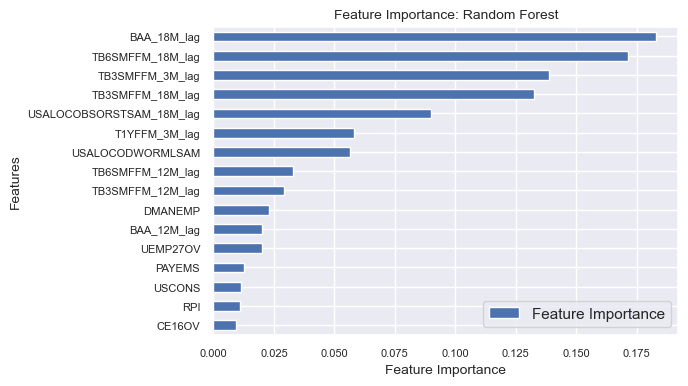

In [24]:
plot_feature_importance(RF, 'Random Forest');

## XGBoost

In [25]:
# XGBoost

# Create and fit XGBClassifier model with silent mode
XGB = xgb.XGBClassifier(silent=True)
XGB.fit(X_train_selected, y_train)

[20:10:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

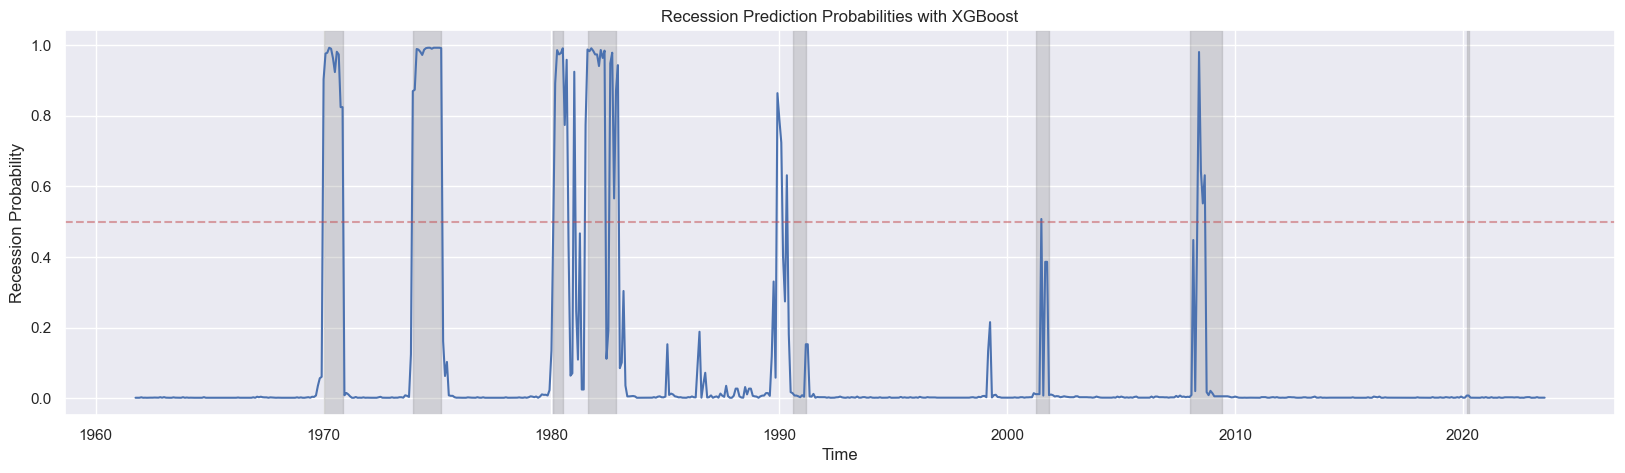

In [26]:
plot_recession_probabilities(XGB, 'XGBoost');

In [27]:
evaluate_model(XGB, 'XGBoost')

----------------- Training set: XGBoost --------------------
[[192   0]
 [  0  27]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       192
         1.0       1.00      1.00      1.00        27

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219

----------------- Test set: XGBoost ------------------------
[[457   9]
 [ 33  25]]
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       466
         1.0       0.74      0.43      0.54        58

    accuracy                           0.92       524
   macro avg       0.83      0.71      0.75       524
weighted avg       0.91      0.92      0.91       524



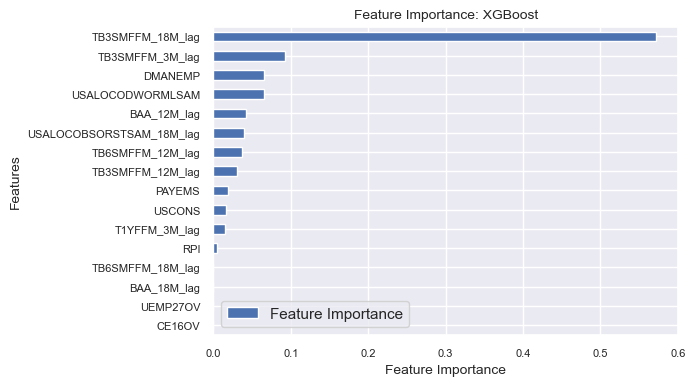

In [28]:
plot_feature_importance(XGB, 'XGBoost');

# Cross Validation

In [29]:
# Define models
seed = 42
models = [
    ('LR', LogisticRegression(class_weight='balanced', random_state=seed)),
    ('LR_L1', LogisticRegression(C=selected_alpha, penalty='l1', solver='saga', class_weight='balanced', random_state=seed)),
    ('LR_L2', LogisticRegression(C=selected_alpha, penalty='l2', solver='saga', class_weight='balanced', random_state=seed)),
    ('DT', DecisionTreeClassifier(splitter='best', random_state=seed)),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('GB', GradientBoostingClassifier(random_state=seed)),
    ('ABC', AdaBoostClassifier(random_state=seed)),
    ('SVC', SVC(class_weight='balanced', probability=True, random_state=seed)),
    ('RF', RandomForestClassifier(random_state=seed)),
    ('XGB', xgb.XGBClassifier(silent=True))
]

LR: 0.962963 (0.037037)
LR_L1: 0.925926 (0.074074)
LR_L2: 0.972222 (0.027778)
DT: 0.895062 (0.083276)
LDA: 0.858025 (0.062951)
KNN: 0.888889 (0.084186)
GB: 0.944444 (0.055556)
ABC: 0.895062 (0.083276)
SVC: 0.861111 (0.138889)
RF: 0.901235 (0.083276)
[20:11:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:11:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:11:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:11:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

XGB: 0.895062 (0.083276)


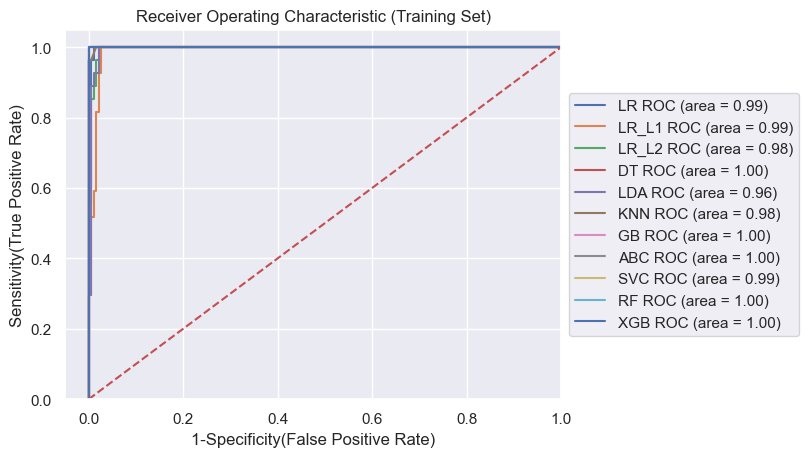

In [30]:
num_splits = 3
kfold = TimeSeriesSplit(n_splits=num_splits)
scoring = 'roc_auc' # roc-auc may not be appropriate for this case due to class imbalance

# Cross-validation
results = []
names = []
for name, model in models:
  cv_results = cross_val_score(estimator=model, X=X_train_selected, y=y_train, cv=kfold) # use default scoring
  # cv_results = cross_val_score(estimator=model, X=X_train_selected, y=y_train, cv=kfold, scoring=scoring) # use specified scoring
  results.append(cv_results)
  names.append(name)
  model.fit(X_train_selected, y_train)

  fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_selected)[:,1])
  auc = roc_auc_score(y_train, model.predict(X_train_selected))
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))

  # cv_metrics = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # simple mean
  cv_metrics = "%s: %f (%f)" % (name, np.nanmean(cv_results), np.nanstd(cv_results)) # mean without 'nan'
  print(cv_metrics)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Training Set)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

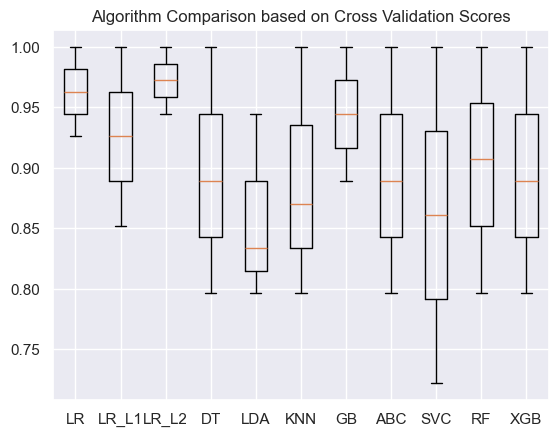

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Remove 'nan' from results
filtered_results = [np.array(arr)[~np.isnan(arr)] for arr in results]
plt.boxplot(filtered_results, showfliers=False) # plot without 'nan'
# plt.boxplot(results) # plot without removing 'nan'

ax.set_xticklabels(names)
ax.set_title("Algorithm Comparison based on Cross Validation Scores");